In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import os 
from torch_geometric.data import DataLoader

from Chromatin3D.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from Chromatin3D.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from Chromatin3D.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear, TransConf, train_trans_conf, evaluate_trans_conf
from Chromatin3D.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from Chromatin3D.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled
from Chromatin3D.Model.lddt_tools import lddt, get_confidence_metrics
from Chromatin3D.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

NB_HEAD = 2
NB_HIDDEN = 100
NB_LAYERS = 1
DROPOUT = 0.1
SECD_HID = 48
ZERO_INIT = False
EXPONENT = 1
NUM_BINS_LOGITS = 100
NB_EPOCHS = 91
##47
SEED = 2
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3
ANGLE_PRED = 3
LAMBDA_BIO = 0
LAMBDA_KABSCH = 0.1
LAMBDA_LDDT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
DATA_DIR = os.environ.get('DATA_DIR')
DATA_PATH=f'{DATA_DIR}/biological_trussart_uniform'
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200



In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

800


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.1)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

In [6]:
trussart_hic, trussart_structures = import_trussart_data(DATA_DIR)

In [7]:
distance_loss_fct = torch.nn.MSELoss()

In [8]:
device = torch.device('cpu')
model = TransConf(NB_BINS, ANGLE_PRED, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT, NB_HEAD, NB_HIDDEN, NB_LAYERS, DROPOUT, SECD_HID).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

In [9]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_trans_conf(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_trans_conf(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_trans_conf(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)

    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)

    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0517, Tr K: 0.1555, Tr D: 0.0688, Te B: 0.0522, Te K: 0.1614, Te D: 0.0686, Tr LD: 0.3746, Te LD: 0.3767, Trus: 0.1580
E: 002, Tr B: 0.0515, Tr K: 0.1252, Tr D: 0.0419, Te B: 0.0517, Te K: 0.1275, Te D: 0.0411, Tr LD: 0.3492, Te LD: 0.3471, Trus: 0.1532
E: 003, Tr B: 0.0515, Tr K: 0.1184, Tr D: 0.0404, Te B: 0.0517, Te K: 0.1221, Te D: 0.0404, Tr LD: 0.3438, Te LD: 0.3424, Trus: 0.1356
E: 004, Tr B: 0.0514, Tr K: 0.1146, Tr D: 0.0356, Te B: 0.0517, Te K: 0.1176, Te D: 0.0353, Tr LD: 0.3382, Te LD: 0.3368, Trus: 0.1292
E: 005, Tr B: 0.0515, Tr K: 0.1105, Tr D: 0.0356, Te B: 0.0518, Te K: 0.1137, Te D: 0.0349, Tr LD: 0.3368, Te LD: 0.3353, Trus: 0.1156
E: 006, Tr B: 0.0514, Tr K: 0.1073, Tr D: 0.0328, Te B: 0.0516, Te K: 0.1100, Te D: 0.0324, Tr LD: 0.3315, Te LD: 0.3307, Trus: 0.1044
E: 007, Tr B: 0.0515, Tr K: 0.1067, Tr D: 0.0329, Te B: 0.0516, Te K: 0.1090, Te D: 0.0324, Tr LD: 0.3319, Te LD: 0.3319, Trus: 0.0965
E: 008, Tr B: 0.0514, Tr K: 0.1029, Tr D: 0.0313, Te B:

In [10]:
print(np.where(trussart_test_kabsch_losses_all_epochs == min(trussart_test_kabsch_losses_all_epochs)))
print(min(trussart_test_kabsch_losses_all_epochs))

(array([71]),)
0.020190032094693198


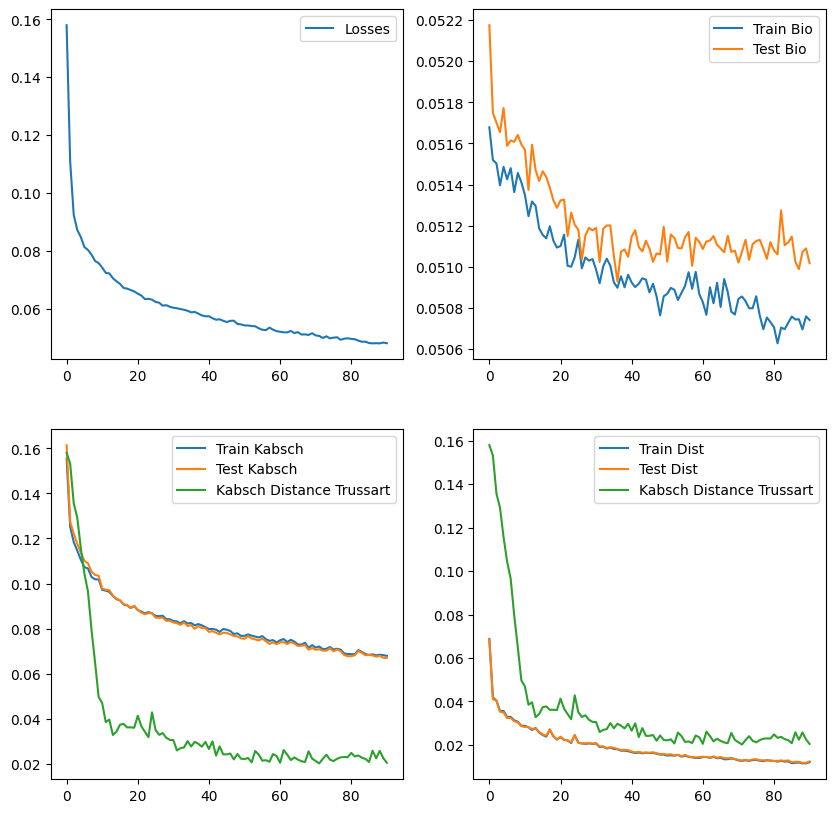

In [11]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, trussart_test_kabsch_losses_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


tensor(0.0001)
transformer_encoder.encoder_layers.self_attn.in_proj_weight
tensor(9.3022e-05)
transformer_encoder.encoder_layers.self_attn.out_proj.weight
tensor(0.0001)
transformer_encoder.encoder_layers.linear1.weight
tensor(9.7442e-05)
transformer_encoder.encoder_layers.linear2.weight
tensor(0.0003)
transformer_encoder.encoder_layers.norm1.weight
tensor(0.0003)
transformer_encoder.encoder_layers.norm2.weight
tensor(0.0001)
transformer_encoder.encoder_layers2.self_attn.in_proj_weight
tensor(5.6714e-05)
transformer_encoder.encoder_layers2.self_attn.out_proj.weight
tensor(0.0001)
transformer_encoder.encoder_layers2.linear1.weight
tensor(4.6857e-05)
transformer_encoder.encoder_layers2.linear2.weight
tensor(0.0002)
transformer_encoder.encoder_layers2.norm1.weight
tensor(0.0002)
transformer_encoder.encoder_layers2.norm2.weight
tensor(0.0001)
transformer_encoder.encoder.weight
tensor(0.0019)
transformer_encoder.decoder.weight
tensor(2.3553e-05)
linear_bin_layer.weight
tensor(1.2350e-05)
li

/Users/hva/Documents/3D-Chromatin/Chromatin3D/Data_Tools/Data_Plotting.py:107: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



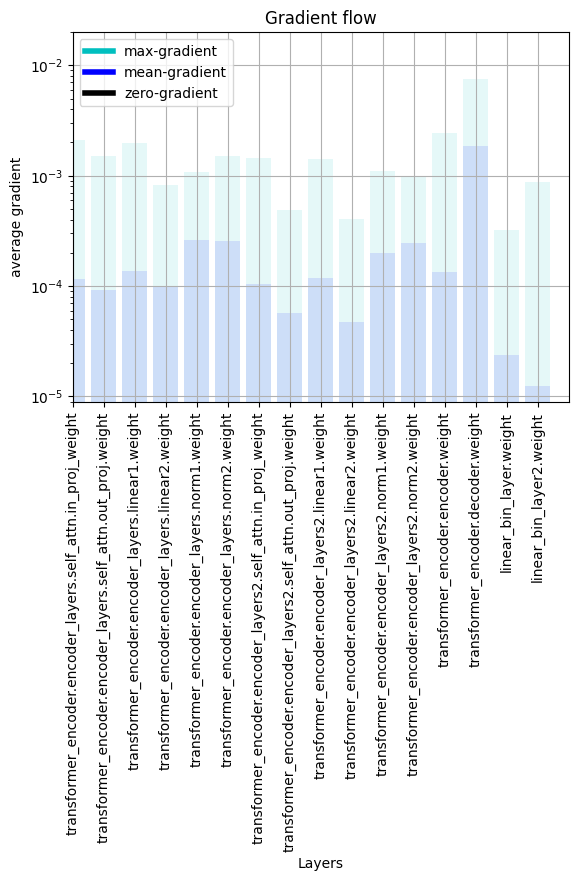

In [12]:
plot_grad_flow(model.named_parameters())

In [13]:
GRAPH_TESTED = 0

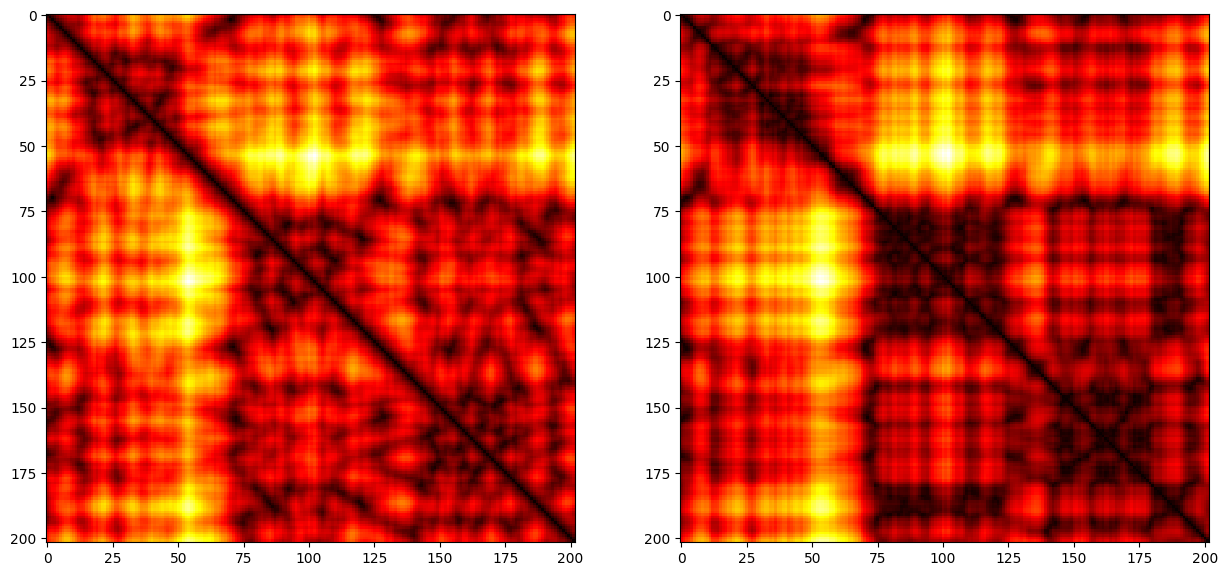

In [14]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)

In [15]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.10004350321807871


<Figure size 50000x50000 with 0 Axes>

In [16]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]
pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
d = np.negative(np.log(np.mean(np.divide(np.abs(pred_structure_unit_ball - true_structure_unit_ball),np.abs(true_structure_unit_ball)), axis=1)))

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = d
color1 = 'Viridis'
color2 = 'magma'
plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.10004350321807871


<Figure size 50000x50000 with 0 Axes>

In [17]:
random_structure = np.random.random((202,3))
test_true_structure = test_true_structures[GRAPH_TESTED]
print(lddt(torch.from_numpy(test_pred_structure_superposed).unsqueeze(0), torch.from_numpy(test_true_structure_superposed).unsqueeze(0)))

random_structure_superposed, true_to_random_structure_superposed = \
        kabsch_superimposition_numpy(random_structure, test_true_structure, EMBEDDING_SIZE)

print(lddt(torch.from_numpy(random_structure_superposed).unsqueeze(0), torch.from_numpy(true_to_random_structure_superposed).unsqueeze(0)))
#print(test_true_structures[GRAPH_TESTED].shape)


tensor([0.8260], dtype=torch.float64)
tensor([0.5416], dtype=torch.float64)


In [18]:
make_gif("", "gifs/trussart_linear.gif")

In [19]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, trussart_pred_distance, trussart_pred_logits = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.01981913456383467


<Figure size 50000x50000 with 0 Axes>

In [20]:
confidence_metrics, pLLDTs = get_confidence_metrics(trussart_pred_logits.detach().numpy()[0])
print(confidence_metrics)

value = lddt(torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0),torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0), per_residue=True)
print(torch.mean(value))

#print(pLLDTs)
#print(value)

87.40189346993512
tensor(0.8890, dtype=torch.float64)


In [21]:
color = 'magma'
plot_pred_conf(trussart_pred_structure_superposed, pLLDTs, color)

In [22]:
####Max error to confidence interval
dmat_true = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, :, None] - torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))
dmat_predicted = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, :, None] -
    torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))

dists_to_score = (
    (dmat_true).type(torch.FloatTensor) *(1. - torch.eye(dmat_true.shape[1]))  
)

dist_l1 = torch.abs(dmat_true - dmat_predicted)
relative_error = torch.mean(torch.div(dist_l1, torch.abs(dmat_true))[0], dim=0)

print(relative_error.shape)
print(torch.topk(torch.mean(dist_l1[0],dim=0), k=10))
print(torch.topk(relative_error, k=10, largest=True))
print(np.argpartition(pLLDTs, 10)[:10])
print(torch.topk(value[0], k=10, largest=False))

torch.Size([202])
torch.return_types.topk(
values=tensor([0.1942, 0.1908, 0.1869, 0.1796, 0.1764, 0.1679, 0.1666, 0.1608, 0.1585,
        0.1524], dtype=torch.float64),
indices=tensor([ 30,  29, 121,  86,  87,  28,  85, 110,  31, 109]))
torch.return_types.topk(
values=tensor([0.2213, 0.2022, 0.2015, 0.1993, 0.1951, 0.1921, 0.1888, 0.1887, 0.1845,
        0.1839], dtype=torch.float64),
indices=tensor([121,  29,  30,  86,  87,  85, 120, 110, 136, 122]))
[74 75 73 76 15  0 77  5  4  1]
torch.return_types.topk(
values=tensor([0.8012, 0.8024, 0.8070, 0.8079, 0.8137, 0.8164, 0.8295, 0.8320, 0.8325,
        0.8352], dtype=torch.float64),
indices=tensor([ 86, 121,  85,  87,  29,  30,  28, 110,  84, 134]))


In [23]:


colorscale1 = -relative_error
colorscale2 = pLLDTs
color1 = 'magma'
color2 = 'magma'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_pred, y_pred, z_pred, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.01981913456383467


<Figure size 50000x50000 with 0 Axes>

In [24]:
orig_model = model
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_test_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model = ModelWithTemperature(orig_model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model.set_temperature(valid_loader)
m = torch.nn.LogSoftmax(dim=1)
nll_criterion = torch.nn.BCEWithLogitsLoss()
print(nll_criterion(m(logits_test_temp), labels_test_temp).item())
logits_test_temps_scaled = scaled_model.temperature_scale(logits_test_temp)

print(nll_criterion(m(logits_test_temps_scaled), labels_test_temp).item())

Before temperature - NLL: 0.037
tensor(0.7392, grad_fn=<MulBackward0>)
tensor(0.7390, grad_fn=<MulBackward0>)
tensor(0.7388, grad_fn=<MulBackward0>)
tensor(0.7386, grad_fn=<MulBackward0>)
tensor(0.7384, grad_fn=<MulBackward0>)
tensor(0.7382, grad_fn=<MulBackward0>)
tensor(0.7380, grad_fn=<MulBackward0>)
tensor(0.7378, grad_fn=<MulBackward0>)
tensor(0.7376, grad_fn=<MulBackward0>)
tensor(0.7375, grad_fn=<MulBackward0>)
tensor(0.7373, grad_fn=<MulBackward0>)
tensor(0.7371, grad_fn=<MulBackward0>)
tensor(0.7370, grad_fn=<MulBackward0>)
tensor(0.7368, grad_fn=<MulBackward0>)
tensor(0.7367, grad_fn=<MulBackward0>)
tensor(0.7365, grad_fn=<MulBackward0>)
tensor(0.7364, grad_fn=<MulBackward0>)
tensor(0.7363, grad_fn=<MulBackward0>)
tensor(0.7362, grad_fn=<MulBackward0>)
tensor(0.7360, grad_fn=<MulBackward0>)
tensor(0.7359, grad_fn=<MulBackward0>)
tensor(0.7358, grad_fn=<MulBackward0>)
tensor(0.7357, grad_fn=<MulBackward0>)
tensor(0.7356, grad_fn=<MulBackward0>)
tensor(0.7356, grad_fn=<MulBackw

In [25]:
confidence_metric_scaled, plddt_scaled = scale_logits(trussart_pred_logits, scaled_model, BATCH_SIZE, NB_BINS)
print(confidence_metric_scaled)
print(plddt_scaled)

87.16359724411674
[85.11408839 85.51448705 85.90448494 85.66894221 85.45541231 85.47178075
 85.60807896 86.2953406  87.02389567 87.24149134 87.37299474 86.90871528
 86.24442301 85.85047242 85.61419405 85.34138527 85.66350208 85.84507754
 86.11938171 86.61601977 86.93941779 87.42913889 87.56574761 87.56708108
 87.46424113 87.5038012  87.57854605 87.50598935 87.3456141  87.22992816
 87.49263413 87.8237813  88.02641529 88.15031835 88.23551709 88.28648107
 88.6308311  89.10924046 89.52424219 89.53397569 89.64855991 89.39439864
 88.96564209 88.4269665  87.76422029 87.15612605 86.8130569  87.3634239
 87.41791555 87.38838568 87.39839838 87.29375226 86.99338892 86.85461796
 87.04491314 87.46147905 87.99518625 88.25156061 88.53794529 88.17147253
 87.76244837 87.42413498 87.0385426  86.98806348 87.16431955 87.34622688
 86.90178917 86.6251102  86.65947652 86.31417299 86.17800115 85.91668814
 85.67043086 85.13884564 84.70918554 84.68301056 84.66695998 85.32717924
 85.9330899  85.92338839 85.879878

In [26]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, plddt_scaled)
print(mse_unscalled)
print(mse_scalled)

10.393983995163895
11.167240289515755


In [27]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [28]:
confidence_metric_iso, pLDDT_iso = isotonic_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_iso)
print(pLDDT_iso)

2.756900640243482
2.697112961997031
88.2449977498551
[86.26994307 86.69946038 87.14500983 86.98640928 86.81191321 86.8057179
 87.03431412 87.58347057 88.19287325 88.33188703 88.3884157  88.09584225
 87.37313105 86.98903285 86.69328317 86.47612945 86.87522892 87.17435168
 87.3570584  87.63147455 88.08357608 88.40127475 88.48778034 88.46386208
 88.44045836 88.52117886 88.51072476 88.50246921 88.44411193 88.40881319
 88.55231596 88.68223901 88.79550457 88.80203471 88.88592011 88.94205288
 89.26111877 89.66627434 90.10252568 90.15340071 90.25017086 89.88833873
 89.50108537 89.14733629 88.69259985 88.36450574 88.12990587 88.45288667
 88.56922151 88.62252373 88.59909718 88.52111206 88.25969137 88.14533568
 88.31208245 88.57389901 88.96693885 89.0951346  89.21460044 89.04134433
 88.76877761 88.50945919 88.33554021 88.30445689 88.38740077 88.54289641
 88.2324647  87.92780641 87.90499742 87.51075088 87.41160719 87.26677742
 87.07196153 86.40862478 85.9796735  85.96424128 85.89163951 86.55625068

In [29]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_iso)
print(mse_unscalled)
print(mse_scalled)

10.393983995163895
8.644801410046824


In [30]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [31]:
confidence_metric_beta, pLDDT_beta = beta_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_beta)
print(pLDDT_beta)

2.756900640243482
2.666184155887241
88.17117947667309
[86.39771495 86.70989154 87.05607688 86.90239782 86.75349302 86.74870214
 86.87770012 87.45499496 88.04336331 88.22093146 88.2857261  87.89255593
 87.32298613 86.93751487 86.69790807 86.49512069 86.82074337 86.99857485
 87.22101716 87.60999999 87.90093752 88.31388679 88.42818983 88.43709678
 88.37251112 88.41208968 88.4933501  88.45866243 88.3214043  88.25750624
 88.47057081 88.7112188  88.82884597 88.91864962 88.96849974 89.02238804
 89.29513204 89.66465378 89.99042414 89.98269107 90.0700332  89.89784533
 89.6033227  89.21562724 88.73362457 88.20870222 87.96889065 88.38336191
 88.49275279 88.54824596 88.51411665 88.40864708 88.16725587 87.9980567
 88.16332756 88.52702935 88.92307816 89.1131226  89.27814307 89.0502029
 88.76723785 88.44231125 88.20222821 88.12677143 88.29787137 88.4357844
 88.10123453 87.79053837 87.75738705 87.45449842 87.32992308 87.11910448
 86.90125629 86.46076476 86.06182517 85.97576424 85.96679    86.58386266


In [32]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_beta)
print(mse_unscalled)
print(mse_scalled)

10.393983995163895
8.719861338993798


In [33]:
color = 'magma'
plot_pred_conf(trussart_pred_structure_superposed, pLDDT_iso, color)

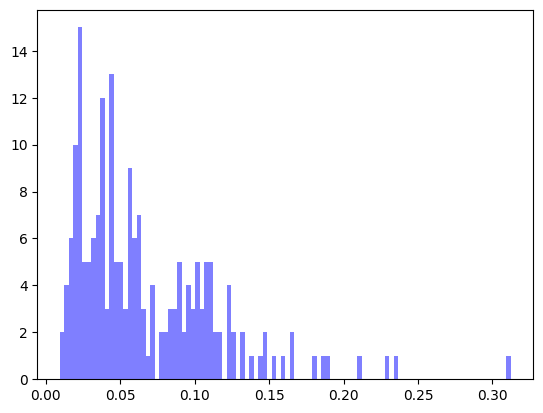

mean: 0.06701403159808708
median: 0.05358150138096568
variance: 0.002255476050665103


In [34]:
plot_hist_kabsch_distances(test_size, test_true_structures, test_pred_structures, EMBEDDING_SIZE)

In [35]:
RESULTS_ROOT = '../../saved_results/synthetic_biological_trussart_uniform_trans_conf/trans/'
LAMBDA_CONFIGURATION = str(LAMBDA_BIO) + '_' + str(LAMBDA_KABSCH)

In [36]:
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_losses_' + LAMBDA_CONFIGURATION + '.txt', losses)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_train_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', train_biological_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_test_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', test_biological_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_train_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', train_kabsch_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_test_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_kabsch_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_train_distance_losses_all_epochs_' +
           LAMBDA_CONFIGURATION + '.txt', train_distance_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_test_distance_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_distance_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_trussart_test_kabsch_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', trussart_test_kabsch_losses_all_epochs)

In [37]:
torch.save(model, 
           '../../saved_models/synthetic_biological_trussart_uniform_trans_conf/trans/synthetic_biological_trussart_uniform_linear_model_' + 
           LAMBDA_CONFIGURATION + '.pt')